In [ ]:
!pip install --upgrade opencv-python-headless==4.9.0.80 mtcnn keras-facenet scikit-learn matplotlib

KeyboardInterrupt: 

In [ ]:
!pip -q install mtcnn keras-facenet opencv-python-headless==4.8.0.74 scikit-learn matplotlib

In [ ]:
!pip install --upgrade pip
!pip install numpy==1.26.4
!pip install opencv-python-headless==4.9.0.80 mtcnn keras-facenet scikit-learn matplotlib

In [ ]:
!pip install scikit-learn
from sklearn.datasets import fetch_lfw_people

lfw = fetch_lfw_people(min_faces_per_person=20, resize=0.5, color=True)
print(lfw.target_names)

['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Serena Williams' 'Silvio Berlusconi' 'Tiger Woods' 'Tom Das

In [ ]:
import os, glob, cv2, numpy as np
from mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
detector = MTCNN()
embedder = FaceNet()
l2_normalizer = Normalizer('l2')

In [ ]:
def detect_faces_bgr(img_bgr, min_size=40):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dets = detector.detect_faces(img_rgb)
    boxes = []
    for d in dets:
        x,y,w,h = d['box']
        if w >= min_size and h >= min_size:
            boxes.append((max(0,x), max(0,y), w, h))
    return boxes

def extract_face_chip(img_bgr, box, size=160):
    x,y,w,h = box
    face = img_bgr[y:y+h, x:x+w]
    face = cv2.resize(face, (size, size))
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face_rgb = face_rgb.astype('float32') / 255.0
    return face_rgb

def embed_faces(faces_rgb):
    if len(faces_rgb) == 0:
        return np.empty((0,512))
    embs = embedder.embeddings(np.array(faces_rgb))
    embs = l2_normalizer.transform(embs)
    return embs


In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

lfw = fetch_lfw_people(min_faces_per_person=20, resize=0.5, color=True)

print("Classes disponíveis:", lfw.target_names[:10], "...")
print("Shape das imagens:", lfw.images.shape)

X_train_img, X_val_img, y_train, y_val = train_test_split(
    lfw.images, lfw.target, test_size=0.2, stratify=lfw.target, random_state=42
)

import cv2
def resize_faces(X):
    X_resized = []
    for img in X:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        face = cv2.resize(img_bgr, (160,160))
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face_rgb = face_rgb.astype("float32")/255.0
        X_resized.append(face_rgb)
    return np.array(X_resized)

X_train_img = resize_faces(X_train_img)
X_val_img   = resize_faces(X_val_img)

print("Dataset pronto:", X_train_img.shape, X_val_img.shape)


Classes disponíveis: ['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem'] ...
Shape das imagens: (3023, 62, 47, 3)
Dataset pronto: (2418, 160, 160, 3) (605, 160, 160, 3)


In [ ]:
X_train = embed_faces(list(X_train_img))
X_val   = embed_faces(list(X_val_img))

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)

76/76 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

clf = SVC(C=10, kernel='rbf', probability=True)
clf.fit(X_train, y_train_enc)

y_pred = clf.predict(X_val)


target_names = [str(c) for c in le.classes_]
print(classification_report(y_val_enc, y_pred, target_names=target_names))

print(confusion_matrix(y_val_enc, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00        24
          13       0.00      0.00      0.00         4
          14       0.18      1.00      0.30       106
          15       0.00      0.00      0.00        22
          16       0.00      0.00      0.00         9
          17       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
def recognize_face(img_rgb):

    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    face = cv2.resize(img_bgr, (160,160))
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face_rgb = face_rgb.astype("float32")/255.0

    emb = embed_faces([face_rgb])

    probas = clf.predict_proba(emb)[0]
    pred = clf.predict(emb)[0]
    name = le.inverse_transform([pred])[0]
    conf = probas[pred]

    return name, conf


In [ ]:
sample = X_val_img[0]
true_label = le.inverse_transform([y_val_enc[0]])[0]
pred_label, conf = recognize_face(sample)

print(f"Verdadeiro: {true_label}")
print(f"Predito: {pred_label} (confiança {conf:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Verdadeiro: 53
Predito: 14 (confiança 0.18)


In [ ]:
def show_prediction(idx=0):
    img_disp = np.clip(X_val_img[idx] * 255 / X_val_img[idx].max(), 0, 255).astype("uint8")

    img_norm = X_val_img[idx] / X_val_img[idx].max()
    emb = embed_faces([img_norm])

    pred = clf.predict(emb)[0]
    prob = clf.predict_proba(emb)[0][pred]
    true_label = str(le.inverse_transform([y_val_enc[idx]])[0])
    name = str(le.inverse_transform([pred])[0])

    plt.imshow(img_disp)
    plt.axis("off")
    plt.title(f"Verdadeiro: {true_label}\nPredito: {name} ({prob:.2f})")
    plt.show()


In [ ]:
def show_multiple_predictions(n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img_disp = np.clip(X_val_img[i] * 255 / X_val_img[i].max(), 0, 255).astype("uint8")
        img_norm = X_val_img[i] / X_val_img[i].max()
        emb = embed_faces([img_norm])

        pred = clf.predict(emb)[0]
        prob = clf.predict_proba(emb)[0][pred]
        true_label = str(le.inverse_transform([y_val_enc[i]])[0])
        name = str(le.inverse_transform([pred])[0])

        plt.subplot(1, n, i+1)
        plt.imshow(img_disp)
        plt.axis("off")
        plt.title(f"T:{true_label}\nP:{name}\n({prob:.2f})")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


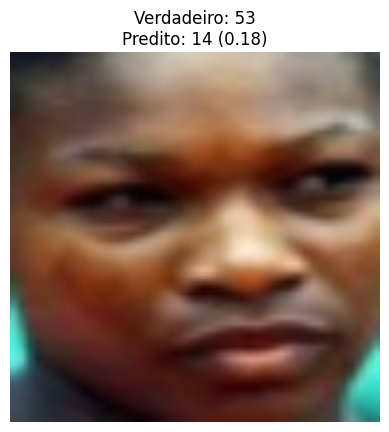

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


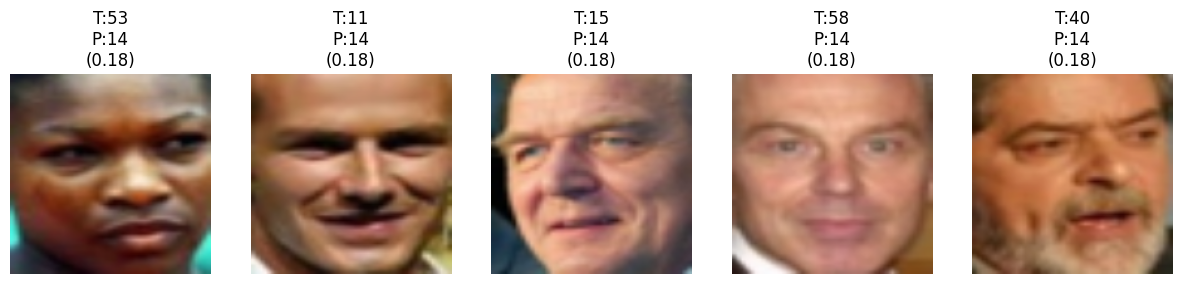

In [ ]:
show_prediction(0)
show_multiple_predictions(5)